In [1]:
import string
import pickle
import re

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/renatomz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
cols = ["candidate", "sentiment", "text", "tweet_created", "retweet_count"]
df = pd.read_csv("Sentiment.csv", parse_dates=["tweet_created"])[cols]
df

,candidate,sentiment,text,tweet_created,retweet_count
0,No candidate mentioned,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46-07:00,5
1,Scott Walker,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46-07:00,26
2,No candidate mentioned,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46-07:00,27
3,No candidate mentioned,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45-07:00,138
4,Donald Trump,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45-07:00,156
...,...,...,...,...,...
13866,No candidate mentioned,Negative,RT @cappy_yarbrough: Love to see men who will ...,2015-08-07 09:29:43-07:00,7
13867,Mike Huckabee,Positive,RT @georgehenryw: Who thought Huckabee exceede...,2015-08-07 09:25:02-07:00,1
13868,Ted Cruz,Positive,"RT @Lrihendry: #TedCruz As President, I will a...",2015-08-07 07:19:18-07:00,67
13869,Donald Trump,Negative,RT @JRehling: #GOPDebate Donald Trump says tha...,2015-08-07 09:54:04-07:00,149


# Text cleaning

In [4]:
test_text = (
    "RT @DanScavino: #GOPDebate've w/ @realDonaldTrump'll, "
    "extra text's is extra, http://www.t.cor/8S97asz8a4A/8S97asz8a4A, "
    "don't click this http://www.t.cor/8S97asz8a4A"
)

In [5]:
init_pattern = "RT\s@\w+:\s"
re.findall(init_pattern, test_text)

['RT @DanScavino: ']

In [6]:
hashtag_pattern = "#\w+"
re.findall(hashtag_pattern, test_text)

['#GOPDebate']

In [7]:
mention_pattern = "@\w+"
re.findall(mention_pattern, test_text)

['@DanScavino', '@realDonaldTrump']

In [8]:
# This one is nasty! What does the last part do?
link_pattern = "https?://?w{0,3}\.?\w+.\w+/(?:/?\w+)*"
re.findall(link_pattern, test_text)

['http://www.t.cor/8S97asz8a4A/8S97asz8a4A', 'http://www.t.cor/8S97asz8a4A']

In [9]:
contract_pattern = "('(?:s|ll|ve|t))"
re.findall(contract_pattern, test_text)

["'ve", "'ll", "'s", "'t"]

In [10]:
pattern_list = [init_pattern, hashtag_pattern, mention_pattern, link_pattern, contract_pattern]
patterns_to_rm = f"({'|'.join(pattern_list)})"
re.findall(patterns_to_rm, test_text)

[('RT @DanScavino: ', ''),
 ('#GOPDebate', ''),
 ("'ve", "'ve"),
 ('@realDonaldTrump', ''),
 ("'ll", "'ll"),
 ("'s", "'s"),
 ('http://www.t.cor/8S97asz8a4A/8S97asz8a4A', ''),
 ("'t", "'t"),
 ('http://www.t.cor/8S97asz8a4A', '')]

In [11]:
re.sub(patterns_to_rm, '', test_text)

' w/ , extra text is extra, , don click this '

In [12]:
words_to_rm = (
    set(stopwords.words("english")) |
    set(string.punctuation) |
    set([]) # any extra words
)

def is_valid(word, words_to_rm):
    # Why not just use the words_to_rm defined in the global scope?
    return (word not in words_to_rm) and (not word.isdigit())

In [13]:
# Input is a string, the output is a cleaned string
def clean(tweet, patterns_to_rm, words_to_rm):
    tweet = re.sub(patterns_to_rm, '', tweet)
    tweet = ' '.join([word 
                      for word in tweet.lower().split() 
                      if is_valid(word, words_to_rm)])
    return tweet

# Adding a new column to our relevant data
df["clean_text"] = df["text"].apply(clean, args=(patterns_to_rm, words_to_rm))
df[["text", "clean_text"]]

,text,clean_text
0,RT @NancyLeeGrahn: How did everyone feel about...,everyone feel climate change question last nig...
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,catch full last night. scott best lines second...
2,RT @TJMShow: No mention of Tamir Rice and the ...,mention tamir rice held cleveland? wow.
3,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending -- hours debate -- men ...
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,w/ delivered highest ratings history president...
...,...,...
13866,RT @cappy_yarbrough: Love to see men who will ...,love see men never faced pregnancy talk body ❤...
13867,RT @georgehenryw: Who thought Huckabee exceede...,thought huckabee exceeded expectations http…
13868,"RT @Lrihendry: #TedCruz As President, I will a...","president, always tell truth, said would do."
13869,RT @JRehling: #GOPDebate Donald Trump says tha...,donald trump says time political correctness. ...


# Question 1

In [14]:
# Create an instance of the analyzer
# https://github.com/cjhutto/vaderSentiment
sentiment_analyzer = SentimentIntensityAnalyzer()

In [15]:
sentiment_analyzer.polarity_scores("this world cup is going to be absolutely fantastic")

{'neg': 0.0, 'neu': 0.673, 'pos': 0.327, 'compound': 0.5984}

In [16]:
sentiment_analyzer.polarity_scores("being a university student is stressful and irritating")

{'neg': 0.558, 'neu': 0.442, 'pos': 0.0, 'compound': -0.743}

In [17]:
# Create columns for the Negative, Neutral, Positive, and Compound scores:
new_cols = ["compound"]

df[new_cols] = 0.0
for idx, text in zip(df.index, df["clean_text"]):
    sent = sentiment_analyzer.polarity_scores(text)
    for key in new_cols:
        df.loc[idx, key] = sent[key]

df

,candidate,sentiment,text,tweet_created,retweet_count,clean_text,compound
0,No candidate mentioned,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46-07:00,5,everyone feel climate change question last nig...,0.0000
1,Scott Walker,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46-07:00,26,catch full last night. scott best lines second...,0.6369
2,No candidate mentioned,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46-07:00,27,mention tamir rice held cleveland? wow.,0.5859
3,No candidate mentioned,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45-07:00,138,carly fiorina trending -- hours debate -- men ...,0.0000
4,Donald Trump,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45-07:00,156,w/ delivered highest ratings history president...,0.0000
...,...,...,...,...,...,...,...
13866,No candidate mentioned,Negative,RT @cappy_yarbrough: Love to see men who will ...,2015-08-07 09:29:43-07:00,7,love see men never faced pregnancy talk body ❤...,0.6369
13867,Mike Huckabee,Positive,RT @georgehenryw: Who thought Huckabee exceede...,2015-08-07 09:25:02-07:00,1,thought huckabee exceeded expectations http…,0.0000
13868,Ted Cruz,Positive,"RT @Lrihendry: #TedCruz As President, I will a...",2015-08-07 07:19:18-07:00,67,"president, always tell truth, said would do.",0.3182
13869,Donald Trump,Negative,RT @JRehling: #GOPDebate Donald Trump says tha...,2015-08-07 09:54:04-07:00,149,donald trump says time political correctness. ...,0.4939


In [18]:
# Create a column that wraps up the Vader predictions nicely
# using np.select to make things FAST
# https://numpy.org/doc/stable/reference/generated/numpy.select.html
conditions = [
    (df["compound"] >=  0.1),
    (df["compound"] <= -0.1)
]
choices = ["Positive", "Negative"]
df["vader_sentiment"] = np.select(conditions, choices, default="Neutral")

In [19]:
df

,candidate,sentiment,text,tweet_created,retweet_count,clean_text,compound,vader_sentiment
0,No candidate mentioned,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,2015-08-07 09:54:46-07:00,5,everyone feel climate change question last nig...,0.0000,Neutral
1,Scott Walker,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,2015-08-07 09:54:46-07:00,26,catch full last night. scott best lines second...,0.6369,Positive
2,No candidate mentioned,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,2015-08-07 09:54:46-07:00,27,mention tamir rice held cleveland? wow.,0.5859,Positive
3,No candidate mentioned,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,2015-08-07 09:54:45-07:00,138,carly fiorina trending -- hours debate -- men ...,0.0000,Neutral
4,Donald Trump,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,2015-08-07 09:54:45-07:00,156,w/ delivered highest ratings history president...,0.0000,Neutral
...,...,...,...,...,...,...,...,...
13866,No candidate mentioned,Negative,RT @cappy_yarbrough: Love to see men who will ...,2015-08-07 09:29:43-07:00,7,love see men never faced pregnancy talk body ❤...,0.6369,Positive
13867,Mike Huckabee,Positive,RT @georgehenryw: Who thought Huckabee exceede...,2015-08-07 09:25:02-07:00,1,thought huckabee exceeded expectations http…,0.0000,Neutral
13868,Ted Cruz,Positive,"RT @Lrihendry: #TedCruz As President, I will a...",2015-08-07 07:19:18-07:00,67,"president, always tell truth, said would do.",0.3182,Positive
13869,Donald Trump,Negative,RT @JRehling: #GOPDebate Donald Trump says tha...,2015-08-07 09:54:04-07:00,149,donald trump says time political correctness. ...,0.4939,Positive


# Question 2

In [20]:
# Let's make a column with agreement between the human-annotated sentiment. 
df["s_agree"] = np.select(
    [df["vader_sentiment"] == df["sentiment"]], 
    ["Agree"], 
    default="Disagree"
)

v_acc = (df["s_agree"] == "Agree").sum() / len(df)
v_acc

0.4097036983634922

# Question 3

In [21]:
sent_map = {"Positive": 1, "Negative":-1, "Neutral":0}
y_human = df["sentiment"].map(sent_map)
y_vader = df["vader_sentiment"].map(sent_map)

opts = {"max_features": 100}
X_bow = CountVectorizer(**opts).fit_transform(df["clean_text"])
X_tfidf = TfidfVectorizer(**opts).fit_transform(df["clean_text"])

In [22]:
def test_model(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    model.fit(X_train, y_train)
    return model, model.predict(X), model.score(X_test, y_test)

In [23]:
rf, rf_pred, rf_acc = test_model(X_tfidf, y_human, RandomForestClassifier())
rf_acc

0.6331090821720327

In [24]:
X_bow.toarray() > 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False]])

In [25]:
bnb, bnb_pred, bnb_acc = test_model(X_bow > 0, y_human, BernoulliNB())
bnb_acc

0.5970687169629986

In [26]:
mnb, mnb_pred, mnb_acc = test_model(X_bow, y_human, MultinomialNB())
mnb_acc

0.5956271023546372

# Question 4

In [27]:
v_acc

0.4097036983634922

# Question 5

In [28]:
# Percent of day complete
df["time_of_day"] = (df["tweet_created"].dt.hour + 
                     df["tweet_created"].dt.minute/60 + 
                     df["tweet_created"].dt.second/3600) / 24

In [29]:
# change this
df["method_sentiment"] = y_human # bnb_pred

df["method_pos"] = df["method_sentiment"] ==  1.0
df["method_neg"] = df["method_sentiment"] == -1.0

In [30]:
df[["candidate", "method_pos", "method_neg"]].groupby("candidate").mean()

,method_pos,method_neg
candidate,,
Ben Carson,0.405941,0.460396
Chris Christie,0.112628,0.744027
Donald Trump,0.216495,0.624956
Jeb Bush,0.062411,0.835461
John Kasich,0.466942,0.338843
Marco Rubio,0.432727,0.381818
Mike Huckabee,0.185751,0.603053
No candidate mentioned,0.090776,0.630623
Rand Paul,0.209125,0.562738


In [31]:
df[["method_sentiment", "retweet_count"]].groupby("method_sentiment").mean()

,retweet_count
method_sentiment,
-1,49.374191
0,37.314768
1,44.168157


In [32]:
df[["time_of_day", "method_pos", "method_neg"]].corr()["time_of_day"]

time_of_day    1.000000
method_pos    -0.019715
method_neg     0.098766
Name: time_of_day, dtype: float64

<Axes: xlabel='time_of_day', ylabel='method_sentiment'>

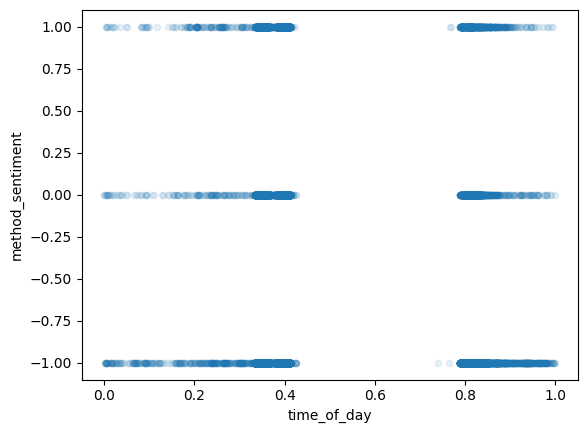

In [33]:
df[["time_of_day", "method_sentiment"]].plot.scatter("time_of_day", "method_sentiment", alpha=0.1)

<Axes: ylabel='Frequency'>

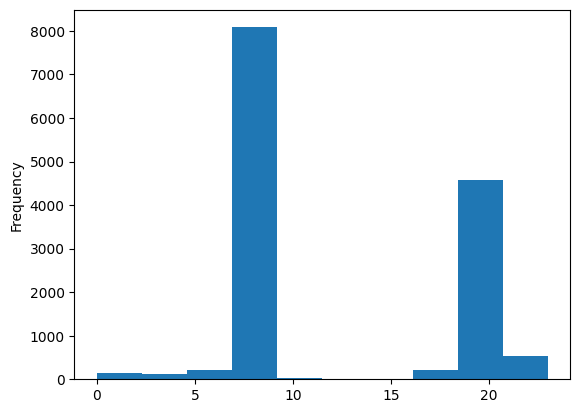

In [34]:
df["tweet_created"].dt.hour.plot.hist()

<Axes: xlabel='hour_of_day'>

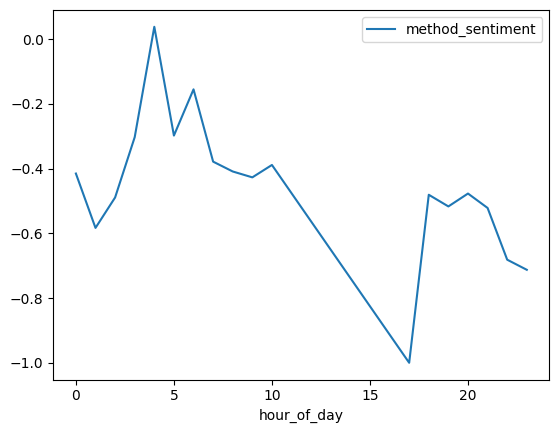

In [35]:
df["hour_of_day"] = df["tweet_created"].dt.hour
df[["hour_of_day", "method_sentiment"]].groupby("hour_of_day").mean().plot()